# Mental Health in Tech Survey

A privacy-preserving statistical release of OSMI data.

The purpose of this demo is to showcase the utility of the OpenDP library. The notebook will focus on statistical releases in the *trusted curator* setting.

Throughout this notebook, we make statistical queries to data with and without privacy-preserving mechanisms. As we compare query results side-by-side, we show that conclusions about the data are similar in both settings: without privacy-preserving mechanism, and with differential privacy mechanism. 
More precisely, the goals of this tutorial are:

- serve an audience with basic understanding of differential privacy
- focus on reproducibility by using open data
- showcase the usability of the OpenDP package
- focus on utility


**Disclaimer:** The present notebook is not intended to serve as a study of mental illness in the tech industry, or make any conclusions about the scenario of mental illness in tech. We use the data set as a illustrative example of the OpenDP tool in survey and human subject studies.

## Dataset Introduction

The mental health in tech survey data set is an open data set licensed under CC BY-SA 4.0. 

The data consists of 27 questions, aswered by 1,259 volunteers. 
For more details on the data set, we refer the reader to the [Mental Health in Tech Survey](https://www.kaggle.com/osmi/mental-health-in-tech-survey).

The data used in the analysis was preprocessed. The original age, gender and country variables were mapped into categories for our analysis. Refer to the [preprocessing script](../data/mental_health_in_tech/preprocess.py) for details on variable mappings.

This analysis will be focused on the following variables:
- **age**: age of the participant. Categorical variable with 5 categories: 21-30yo (0), 31-40yo (1), 41-50yo (2), 51-60yo (3), 60yo+ (4) 
- **gender**: gender declared by the participant, and in the survey the participants could input any string. We categorized answers as follows: Male/Man (1), Female/Woman(2), all other inputs (0).
- **country**: participant's country of residence. We categorized answers as follows: United States (1), United Kingdom (2), Canada (3), other countries (0).
- **remote_work**: binary value that indicates 
    if participant work remotely more than 50% of the time
- **family_history**: binary value that indicates if the 
    participant has a family history of mental illness 
- **treatment**: Binary value that 
    indicates if the participants has seeked 
    treatment for mental illness

## Data Analysis and Exploration

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

from opendp.transformations import *
from opendp.measurements import *
from opendp.combinators import *
from opendp.typing import *
from opendp.mod import *

enable_features("contrib", "honest-but-curious")

import seaborn as sns
sns.set_style("whitegrid", {
    "text.color": "#000000",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "font.size": 42
})
path = '../data/mental_health_in_tech/data.csv'

In [24]:
survey = pd.read_csv(path)
print('Data length: '+ str(len(survey)))
survey.head()

Data length: 1213


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,age,gender,country
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,0,1,Often,6-25,...,Some of them,Yes,No,Maybe,Yes,No,NaN,1,2,1
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,0,0,Rarely,More than 1000,...,No,No,No,No,Don't know,No,NaN,2,1,1
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,0,0,Rarely,6-25,...,Yes,Yes,Yes,Yes,No,No,NaN,1,1,3
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,1,1,Often,26-100,...,Some of them,No,Maybe,Maybe,No,Yes,NaN,1,1,2
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,0,0,Never,100-500,...,Some of them,Yes,Yes,Yes,Don't know,No,NaN,1,1,1


### Characteristics of survey participants

In the following analysis we explore the distribution of participants according to the following variables:
- age
- gender
- country
- remote_work
- family_history
- treatment

We make simple histogram queries for each of the variables.

In [25]:
## Distance information
max_influence = 1
per_query_epsilon = 0.1

## Public information
# These multicategorical variables have these labels on ordinal data:
column_labels = {
    "age": ["21-30 years", "30-39 years", "40-49 years", "50-59 years", "60+ years"],
    "country": ["Other", "US", "UK", "CA"],
    "gender": ["Non-binary", "Male", "Female"],
    "remote_work": ["Does not work remotely", "Works remotely"],
    "family_history": ["Family history of MI", "No family history"],
    "treatment": ["Not Diagnosed", "Diagnosed"],
}

def get_categories(col):
    """underlying data is encoded ordinally"""
    return [str(i) for i in range(len(column_labels[col]))]
    
var_names = list(survey.columns)

## Construct measurement
def make_cal_dp_histogram(col):
    """creates a dp histogram with noise calibrated such that the measurement is (1-sym, .1-eps)-close"""

    def make_dp_histogram(scale):
        """a constructor for a histogram"""
        return (
            make_select_column(col, TOA=str)
            >> make_count_by_categories(get_categories(col), null_category=False)
            >> make_base_discrete_laplace(scale, D=VectorDomain[AllDomain[int]])
            >> make_default_postprocessor(  # clamp negative values
                lambda x: np.absolute(x, dtype=np.int32),
                DI=VectorDomain[AllDomain[int]],
                DO=VectorDomain[AllDomain[int]],
            )
        )

    return binary_search_chain(
        make_dp_histogram,
        d_in=max_influence,
        d_out=per_query_epsilon,
    )


histograms_meas = make_split_dataframe(
    ",", col_names=var_names
) >> make_basic_composition([make_cal_dp_histogram(col) for col in column_labels])

## Invoke with data
file_handle = open(path)
next(file_handle)  # discard header line
data = file_handle.read()
histograms = histograms_meas(data)

## postprocess into a dict so we can easily find outputs
histograms = dict(zip(column_labels.keys(), histograms))

for name, value in histograms.items():
    print(format(name, " >20"), value)


                 age [476, 543, 153, 31, 30]
             country [242, 708, 173, 62]
              gender [18, 955, 239]
         remote_work [812, 349]
      family_history [745, 477]
           treatment [607, 609]


Due to sequential composition, given $q_i$ queries, where each query provides $\epsilon_i$-*differential privacy*, the sequence of queries provides $(\sum \epsilon_i)$-*differential privacy*.

In [26]:
print("Epsilon:", histograms_meas.map(max_influence))

Epsilon: 0.6000000000000002


In [27]:
def pie_builder(label, true_counts, dp_counts, title, subtitle1, subtitle2):
    # Make square figures and axes
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.rcParams["font.size"] = 16

    cmap = plt.get_cmap("GnBu")
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]

    plt.subplot(121, aspect=1, title=subtitle1)
    plt.pie(true_counts, labels=label, autopct="%1.1f%%", shadow=True, colors=colors)
    plt.subplot(122, aspect=1, title=subtitle2)
    plt.pie(dp_counts, labels=label, autopct="%.0f%%", shadow=True, colors=colors)
    plt.suptitle(title)
    plt.show()

def pie_comparison(column):
    pie_builder(
        label=column_labels[column],
        true_counts=np.unique(survey[column], return_counts=True)[1],
        dp_counts=histograms[column],
        title=f"Comparison of Results: Discrete Laplace Mechanism ({per_query_epsilon} ε)-DP",
        subtitle1=f"True Counts: {column}",
        subtitle2=f"Privacy-preserving: {column}",
    )


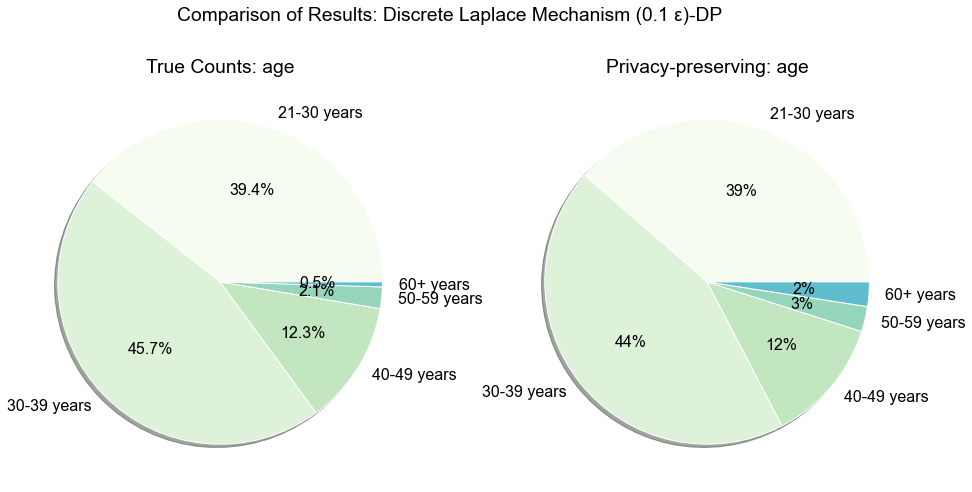

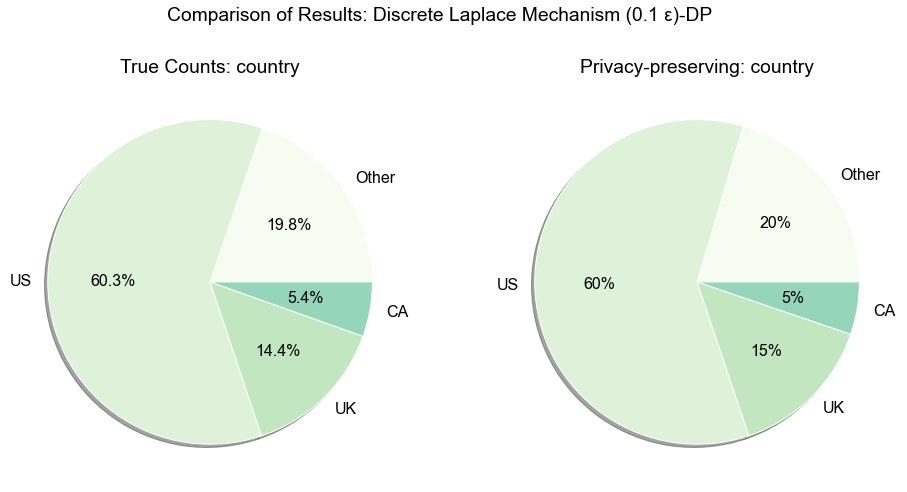

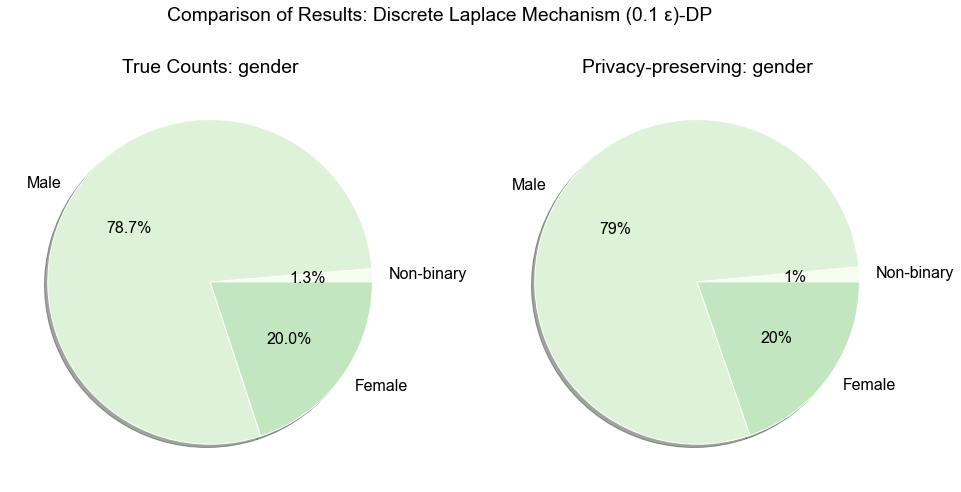

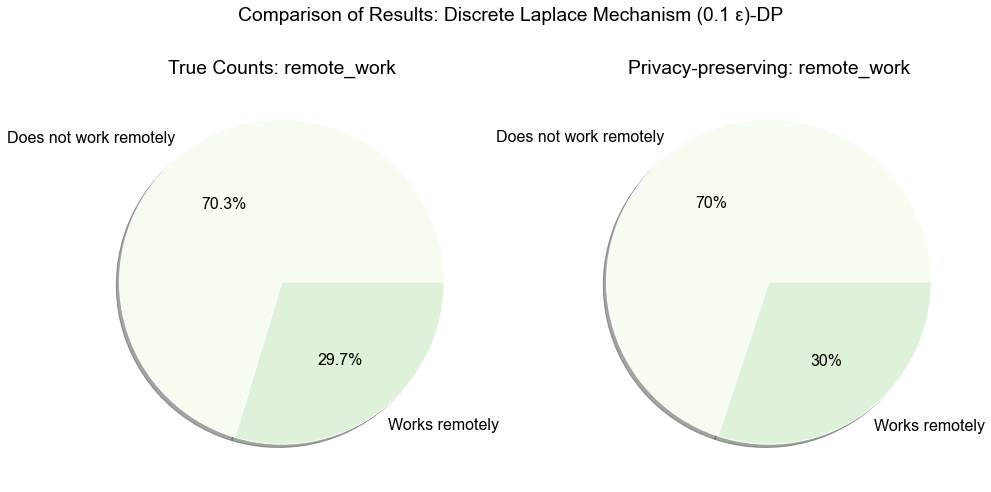

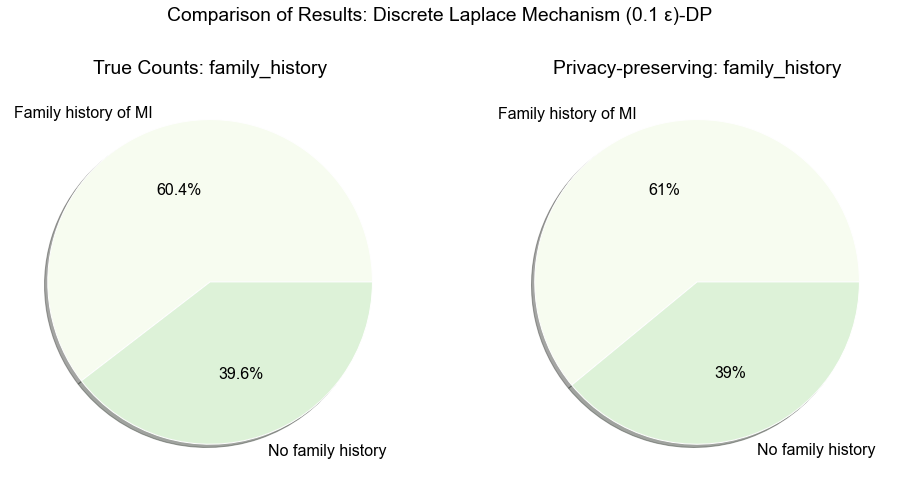

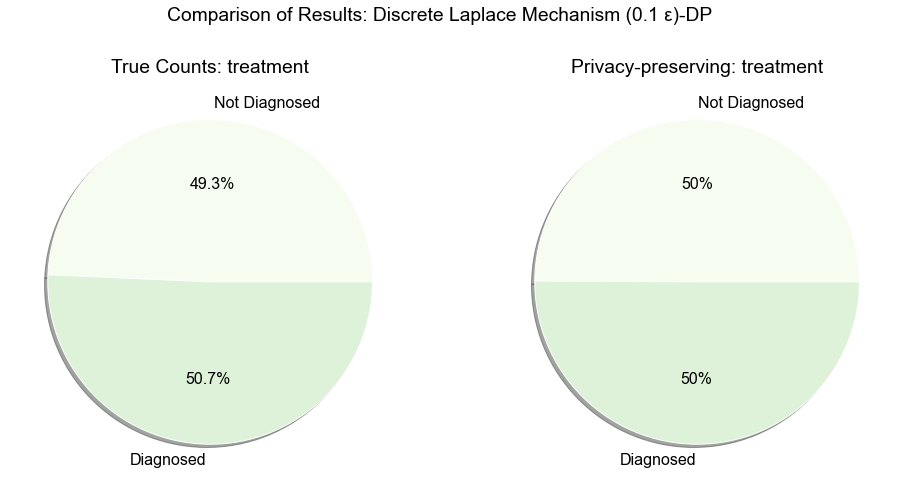

In [28]:
for column in column_labels:
    pie_comparison(column)


### Variable Interactions

For the queries in the following analysis, we will make histogram queries of disjoint subsets of the data.

Due to parallel composition, when queries are applied to disjoint subsets of the data, the privacy guarantee depends only on the maximum $\epsilon_i$, not the sum.

In [29]:
per_query_epsilon = 0.4


def make_cal_dp_marginals(cols):
    """creates a dp marginals query on `cols` with noise calibrated such that the measurement is (1-sym, .4-eps)-close"""

    def make_dp_marginals(scale, cols):
        """a constructor for a marginals query"""
        col, *rest = cols
        cats = get_categories(col)
        if rest:
            inner = [make_dp_marginals(scale, rest)] * len(cats)
        else:
            inner = [
                make_select_column(col, str)
                >> make_count(str)
                >> make_base_discrete_laplace(scale)
            ] * len(cats)
        return make_partition_by(
            col, cats, keep_columns=rest or [col]
        ) >> make_parallel_composition(inner)

    return binary_search_chain(
        lambda s: make_dp_marginals(s, cols),
        d_in=max_influence,
        d_out=per_query_epsilon,
    )


# list the marginal queries we want to make
marginal_query_columns = [col for col in column_labels if col != "treatment"]

marginals_meas = make_split_dataframe(
    ",", col_names=var_names
) >> make_basic_composition(
    [make_cal_dp_marginals(["treatment", col]) for col in marginal_query_columns]
)


Now that we have our computation set up, we make both a DP release and compute the exact aggregates.

In [30]:
noisy_counts = marginals_meas(data)
noisy_counts

[[[253, 273, 63, 5, 2], [224, 283, 81, 20, 0]],
 [[146, 341, 87, 31], [93, 402, 84, 34]],
 [[0, 521, 73], [13, 434, 167]],
 [[423, 171], [423, 191]],
 [[479, 123], [268, 357]]]

In [31]:
def get_exact_marginals(cols):
    df = survey.groupby(cols).size()
    return [list(df[0]), list(df[1])]
exact_counts = [get_exact_marginals(["treatment", col]) for col in marginal_query_columns]
exact_counts

[[[253, 269, 62, 11, 3], [225, 285, 87, 15, 3]],
 [[147, 332, 87, 32], [93, 400, 88, 34]],
 [[3, 520, 75], [13, 435, 167]],
 [[429, 169], [424, 191]],
 [[475, 123], [258, 357]]]

We now reorganize all query results into a dataframe.
This dataframe is a contingency table that displays the frequency distribution of the variables.
Contingency tables are heavily used in survey statistics, business intelligence, engineering and scientific research.

The contingency table will help us explore the relationship between treatment and the other variables.

In [32]:
def as_df(column, noisy_counts, exact_counts):
    cats = column_labels[column]
    return pd.DataFrame({
        'Group': cats * 2,
        'Process': ['true value'] * len(cats) + ['privacy-preserving'] * len(cats),
        'Participants on treatment MI': exact_counts[1] + noisy_counts[1],
        'Participants not on treatment MI': exact_counts[0] + noisy_counts[0],
        'Variable': column
    })
tri_zip = zip(marginal_query_columns, noisy_counts, exact_counts)
DF = pd.concat([as_df(*trio) for trio in tri_zip])

DF["percentage"] = (
    DF["Participants on treatment MI"]
    * 100
    / (DF["Participants not on treatment MI"] + DF["Participants on treatment MI"])
)
DF["Participants on treatment MI"] = DF["Participants on treatment MI"].abs()
DF["Participants not on treatment MI"] = DF["Participants not on treatment MI"].abs()


#### Mental Illness

Participants with family history of mental illness are twice as likely to be diagnosed with mental illness, when compared with participants with no family history.

In [33]:
DF[DF.Variable == 'family_history'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
0,Family history of MI,true value,258,475,family_history,35.197817
2,Family history of MI,privacy-preserving,268,479,family_history,35.876841
1,No family history,true value,357,123,family_history,74.375000
3,No family history,privacy-preserving,357,123,family_history,74.375000


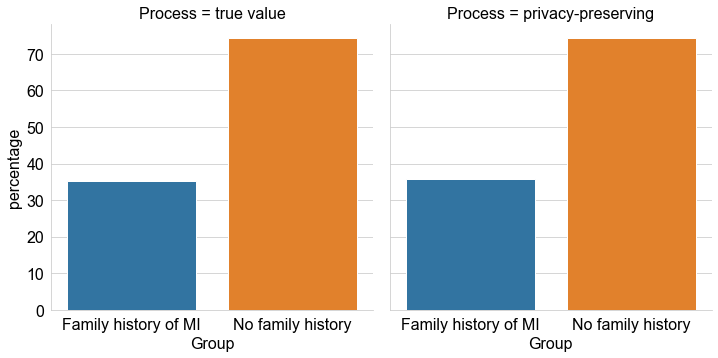

In [34]:
sns.catplot(x="Group", y="percentage", col="Process", data=DF[DF.Variable == 'family_history'], kind="bar");

#### Remote Work

Participants working remotely have the same probability of being diagnosed with mental illness as participants that do not work remotely.

In [35]:
DF[DF.Variable == 'remote_work'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
0,Does not work remotely,true value,424,429,remote_work,49.706917
2,Does not work remotely,privacy-preserving,423,423,remote_work,50.000000
1,Works remotely,true value,191,169,remote_work,53.055556
3,Works remotely,privacy-preserving,191,171,remote_work,52.762431


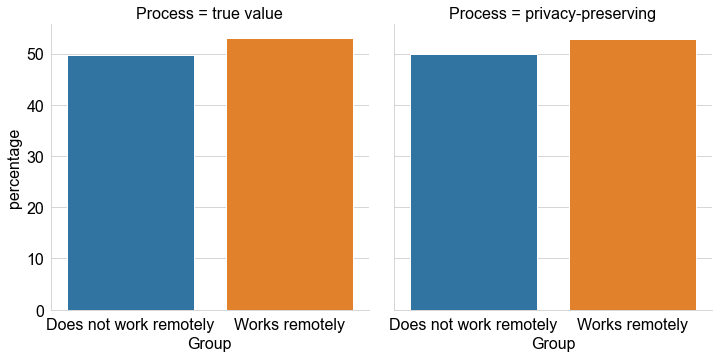

In [36]:
sns.catplot(x="Group", y="percentage", col="Process", data=DF[DF.Variable == 'remote_work'], kind="bar");

#### Country

The US has the biggest percent of professionals in the tech industry diagnosed with mental illness (around 54%). In other countries having the lowest percentages, fewer than 40% of tech workers have been treated for mental illness.

In [37]:
DF[DF.Variable == 'country'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
3,CA,true value,34,32,country,51.515152
7,CA,privacy-preserving,34,31,country,52.307692
0,Other,true value,93,147,country,38.750000
4,Other,privacy-preserving,93,146,country,38.912134
2,UK,true value,88,87,country,50.285714
6,UK,privacy-preserving,84,87,country,49.122807
1,US,true value,400,332,country,54.644809
5,US,privacy-preserving,402,341,country,54.104980


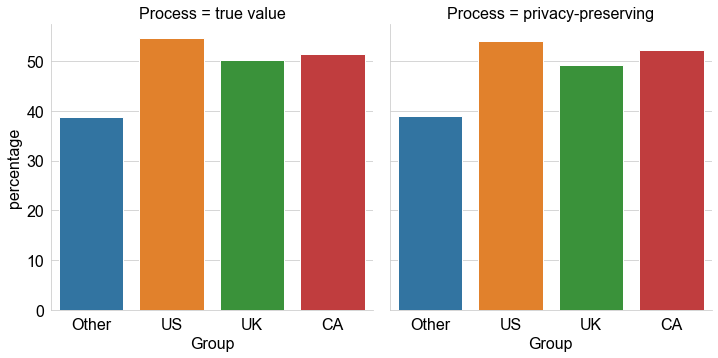

In [38]:
sns.catplot(x="Group", y="percentage", col="Process", data=DF[DF.Variable == 'country'], kind="bar");

#### Age

As we explore the percentage of participants in each age group that sought MI treatment, we observe that very similar conclusions can be drawn from true values and from privacy preserving values. 
The exception is for participants who are 60+ years old. 

As expected, in very small data partitions the distortions dominate the signal.


In [39]:
DF[DF.Variable == 'age'].sort_values(['Group'])

,Group,Process,Participants on treatment MI,Participants not on treatment MI,Variable,percentage
0,21-30 years,true value,225,253,age,47.071130
5,21-30 years,privacy-preserving,224,253,age,46.960168
1,30-39 years,true value,285,269,age,51.444043
6,30-39 years,privacy-preserving,283,273,age,50.899281
2,40-49 years,true value,87,62,age,58.389262
7,40-49 years,privacy-preserving,81,63,age,56.250000
3,50-59 years,true value,15,11,age,57.692308
8,50-59 years,privacy-preserving,20,5,age,80.000000
4,60+ years,true value,3,3,age,50.000000
9,60+ years,privacy-preserving,0,2,age,0.000000


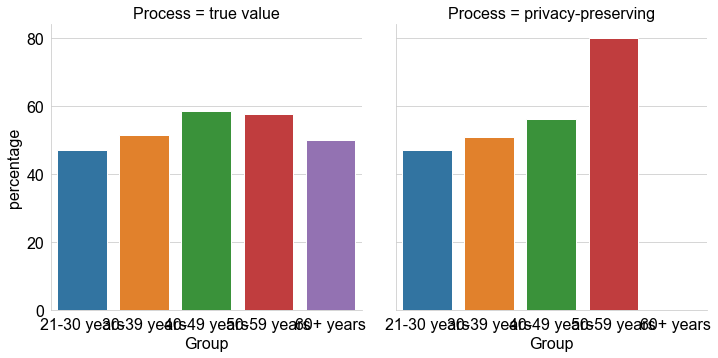

In [40]:
sns.catplot(x="Group", y="percentage", col="Process", data=DF[DF.Variable == 'age'], kind="bar");

## Intercorrelation of two discrete variables

Cramér's V, sometimes referred to as Cramér's phi (denoted as $\phi_c$), is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). 
It is based on Pearson's chi-squared statistic.

$\phi_c$ is the intercorrelation of two discrete variables, and may be used with variables having two or more levels. $\phi_c$ is symmetrical, it does not matter which variable we place in the columns and which in the rows. Also, the order of rows/columns doesn't matter, so $\phi_c$ may be used with nominal data types or higher (notably ordered or numerical).

Source: Wikipedia

In [41]:
def cramers_stat(confusion_matrix):
    """calculate Cramers V statistic for categorical-categorical association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = sum(confusion_matrix.sum())
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [42]:
Coefs_var = ['family_history', 'gender', 'remote_work', 'age', 'country'] 

In [43]:
coefs = []
dpcoefs = []
for variable in Coefs_var:
    coefs.append(
        cramers_stat(
            DF[(DF.Variable == variable) & (DF.Process == "true value")][
                ["Participants on treatment MI", "Participants not on treatment MI"]
            ]
        )
    )
    dpcoefs.append(
        cramers_stat(
            DF[(DF.Variable == variable) & (DF.Process == "privacy-preserving")][
                ["Participants on treatment MI", "Participants not on treatment MI"]
            ]
        )
    )


In [44]:
pd.DataFrame(data={"True Coef": coefs, "Privacy Coef": dpcoefs}, index=Coefs_var)

,True Coef,Privacy Coef
family_history,0.380581,0.373213
gender,0.196000,0.214289
remote_work,0.002006,0.000000
age,0.046954,0.095934
country,0.112341,0.106864


These results are consistent with the previous observations: that patients with a family history of mental illness are more correlated with treatment.

## Privacy by design

An adversarial researcher may try to drill down into the data in order to get information about specific survey participants.
Differential privacy mechanisms are designed to answer such queries with sufficient noise to mask the participation of any individual.
In scenarios without a trusted curator, the library can also provide accuracy intervals. 
An $\alpha$-level accuracy guarantee a promise that (with probability $1-\alpha$)

$$
M(D) \in [M_{DP}(D)-a, M_{DP}(D)+a]
$$

where $M(D)$ is the query response of function $M$ on database $D$ without differential privacy, and $M_{DP}(D)$ is the response with differential privacy.

Accuracy is discussed in more detail on [this documentation page](https://docs.opendp.org/en/stable/user/utilities/accuracy/index.html).